### Libraries

In [33]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

### Load Data

In [34]:
query = "Query_AI-magazines-mediacloud-2021-24" # Load feater file
FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)

df = df[df['text'] != ''] # Drop rows where the 'Name' is empty
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer

df = df.reset_index(drop=True) # Reset the index of the DataFrame and drop the old index column


df.sample(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG
77,741ed661de17e5fded927d0c4bdba223e66ad2785e1b57...,2024-08-14 22:27:28.261555,en,technologyreview.com,technologyreview.com,2024-08-14,DHS plans to collect biometric data from migra...,https://www.technologyreview.com/2024/08/14/10...,2024,The US wants to use facial recognition to iden...,True,"[US, Panama, US, US, Oregon, US, the United St...","[John Boyd, OBIM, Boyd, OBIM, OBIM, Boyd, Boyd...","[The US Department of Homeland Security, DHS, ..."


### Clean Data

In [35]:
def remove_single_word_names(individuals):
    return [name for name in individuals if " " in name] # Function to filter names in 'IND' column
df['IND'] = df['IND'].apply(remove_single_word_names) # Apply the function to the 'IND' column

df = df[df['media_name'].str.contains("technologyreview", na=False)]

def concat_entities(row):
    concat = list(row['GPE']) + list(row['IND']) + list(row['ORG'])
    return list(set(concat))
df['entities'] = df.apply(concat_entities, axis=1) # Merge entities

df = df.drop(['text_downloaded', 'indexed_date', 'language', 'media_url', 'id', 'publish_date', 'media_name', 'GPE', 'IND', 'ORG'], axis=1) # Delete unised arrows

df.sample(3)

,title,url,year,text,entities
309,Why Google’s AI Overviews gets things wrong,https://www.technologyreview.com/2024/05/31/10...,2024,Why Google’s AI Overviews gets things wrong\nG...,"[US, Barack Hussein Obama, Leiden University, ..."
608,"The Download: Twitter killers, and how China r...",https://www.technologyreview.com/2024/01/17/10...,2024,"The Download: Twitter killers, and how China r...","[US, NYCHA, Elon Musk, Sam Altman, the Wall St..."
14,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,"[Marcus Holmström, The Gang, AI, France, Roblo..."


### Temperature

In [36]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,title,url,year,text,entities,temperature,color
1248,"Despite its charms, AI is little more than an ...",https://www.technologyreview.com/2023/04/26/10...,2023,"Despite its charms, AI is little more than an ...","[UN, OpenAI, America, MIT Technology Review, S...",1,#5500aa
733,Google DeepMind wants to define what counts as...,https://www.technologyreview.com/2023/11/16/10...,2023,Google DeepMind wants to define what counts as...,"[Shane Legg, New York University, Julian Togel...",1,#5500aa
141,How’s AI self-regulation going?,https://www.technologyreview.com/2024/07/23/10...,2024,How’s AI self-regulation going?\nOne year on f...,"[the United States, US, The New York Times, Sa...",2,#0000ff


### Term Frequency

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["entities"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

## UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/pointgrid/pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '556.5714285714283' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[site, ['y', 'x']] = [x,y]
/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/pointgrid/pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '567.5324675324679' has dtype incompatible with int64, please explicitly

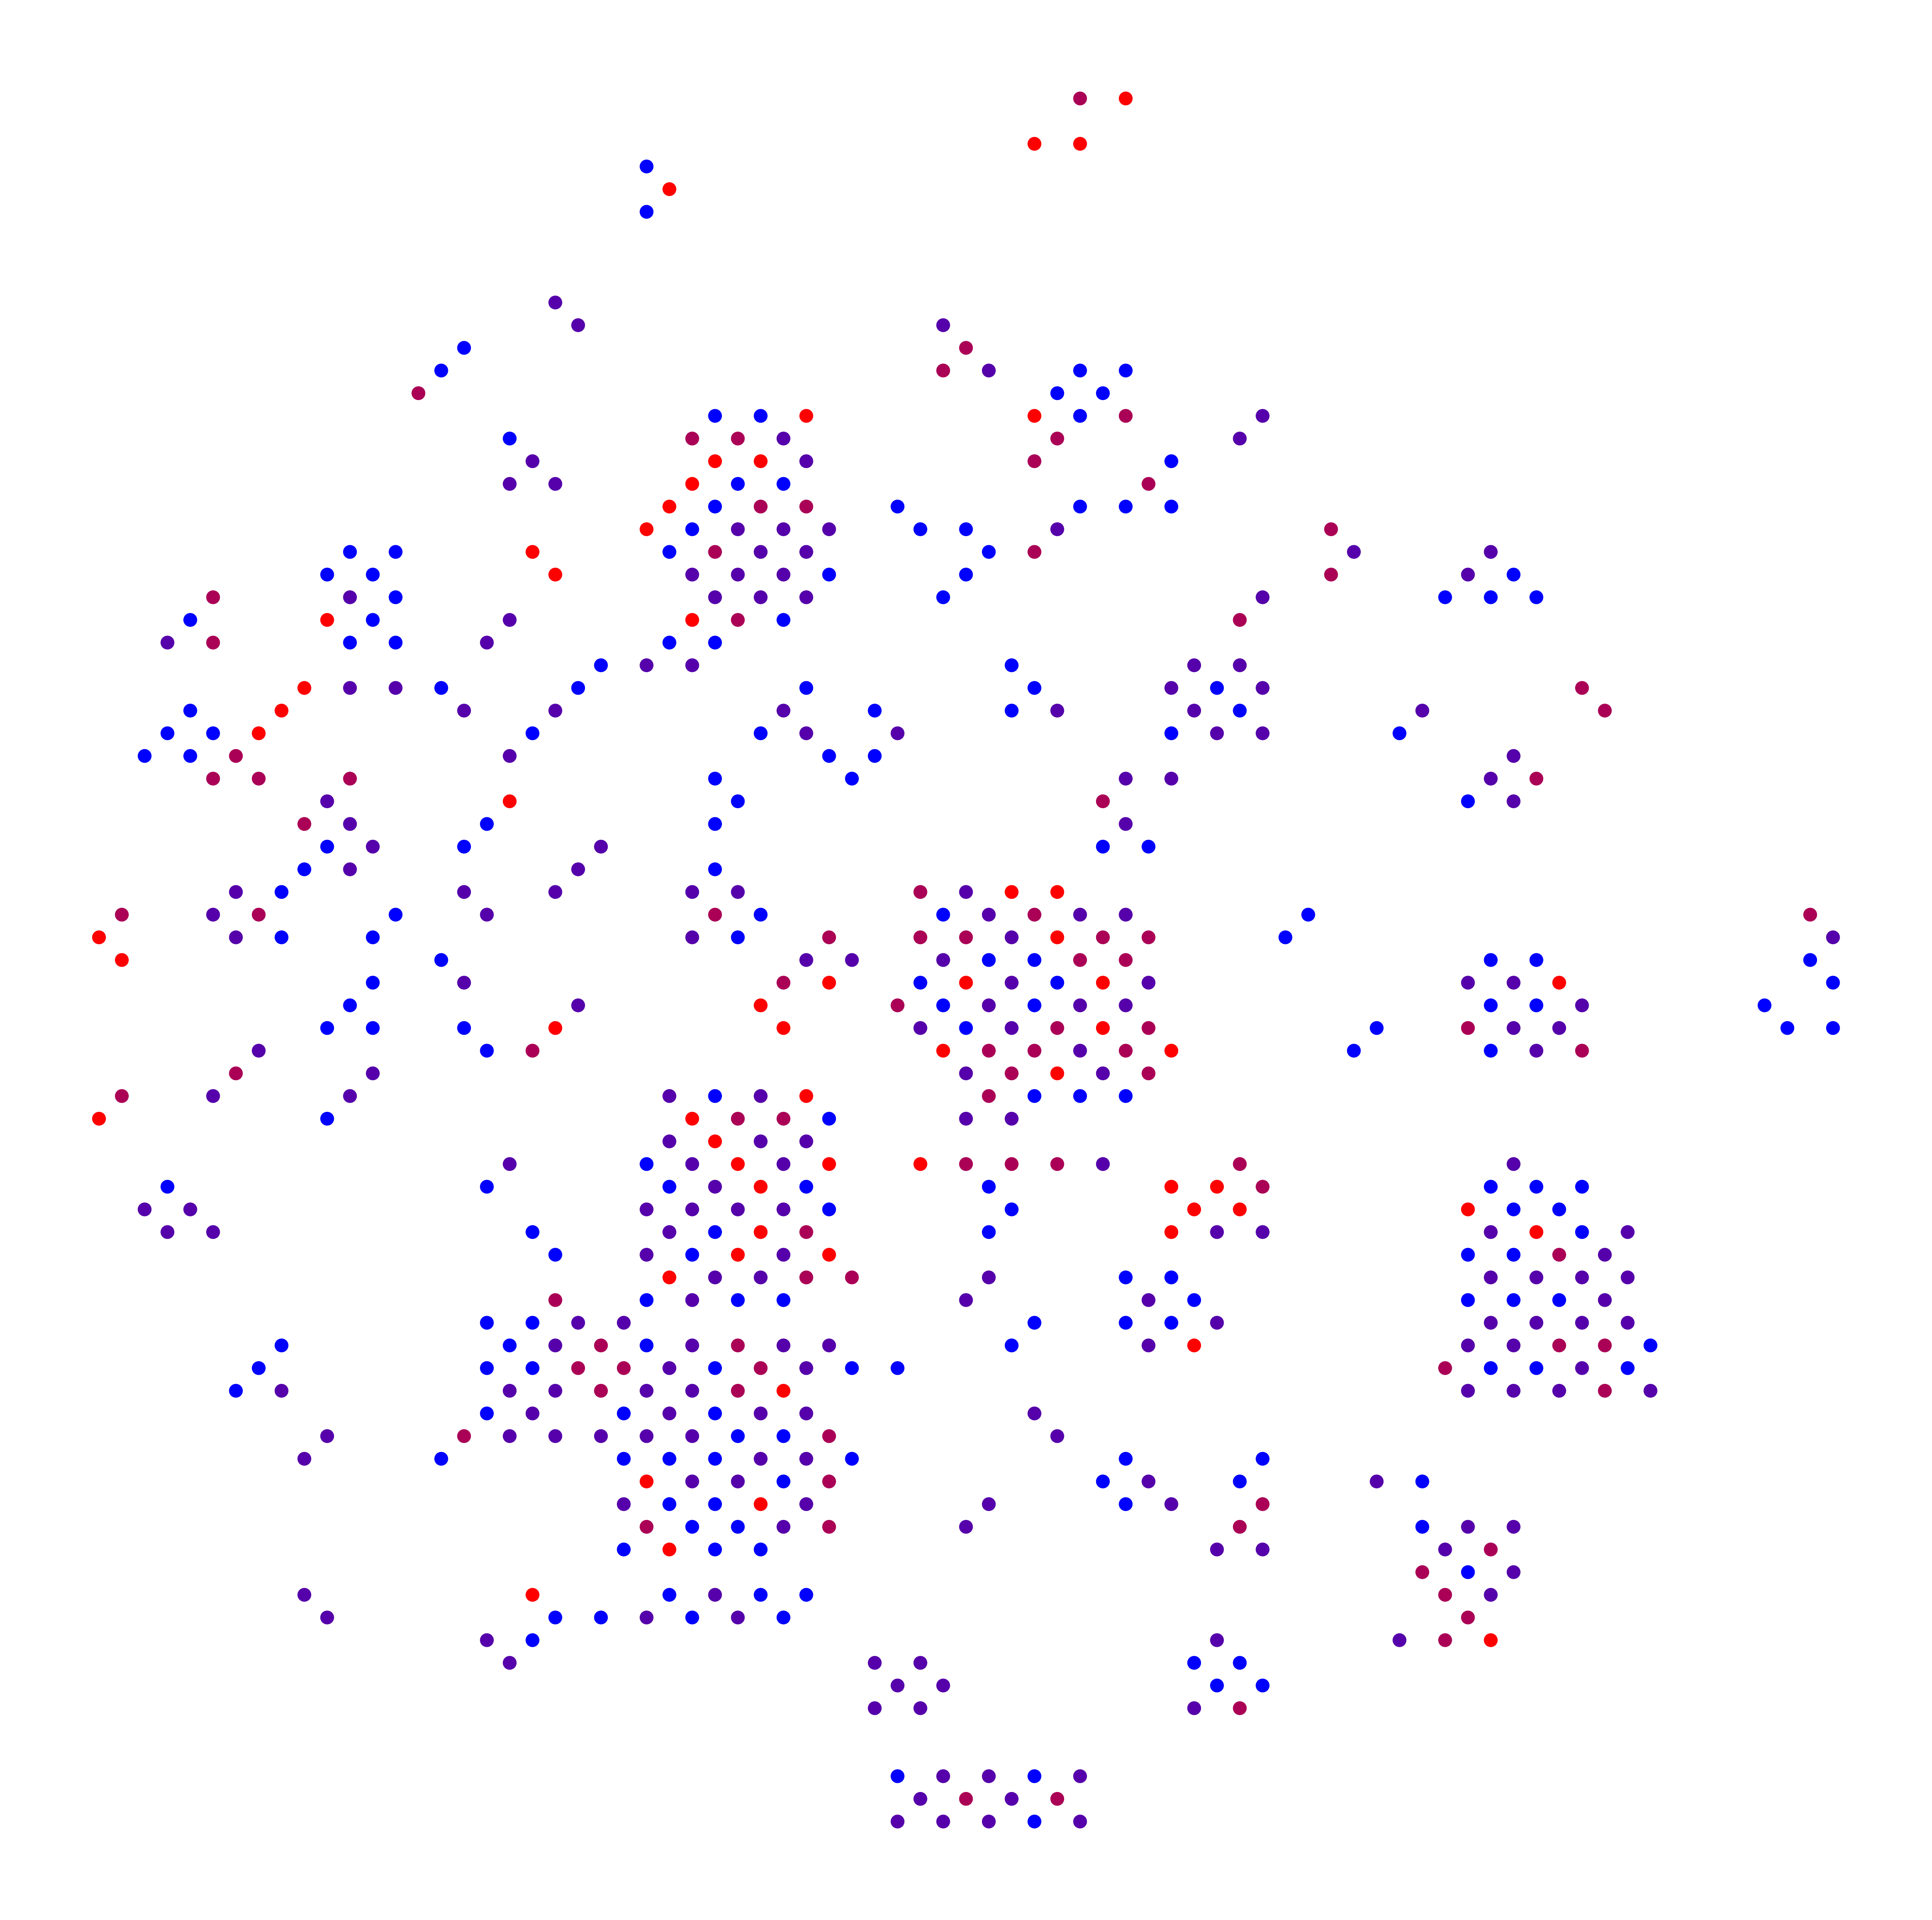

In [38]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    random_state=1,
    n_components=2,
    n_neighbors=2,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")


## Clustering

In [39]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=5,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=5, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

,title,url,year,text,entities,temperature,color,x,y,cluster
746,The Biggest Questions: Are we alone in the uni...,https://www.technologyreview.com/2023/11/13/10...,2023,The Biggest Questions: Are we alone in the uni...,"[Sofia Sheikh, the New York Times, NASA, SETI,...",1,#5500aa,422.077922,494.311688,-1
747,"The Download: are we alone, and private milita...",https://www.technologyreview.com/2023/11/13/10...,2023,"The Download: are we alone, and private milita...","[Li Jiaqi, US, The Technocrat, NSO Group, Sam ...",1,#5500aa,775.324675,307.532468,p_5
531,Watch this robot as it learns to stitch up wounds,https://www.technologyreview.com/2024/02/22/10...,2024,Watch this robot as it learns to stitch up wou...,"[Ken Goldberg, STAR, Super Mario, Genie, the d...",2,#0000ff,380.519481,369.792208,p_11


{'p_14', 'p_4', 'p_6', 'p_17', 'n_1', 'p_7', '-1', 'p_11', 'n_5', 'p_9', 'n_0', 'p_1', 'n_4', 'p_15', 'p_12', 'p_2', 'p_8', 'p_10', 'p_13', 'p_3', 'n_2', 'p_16', 'n_3', 'p_0', 'p_5'}


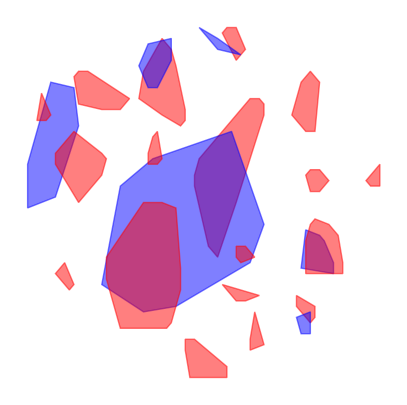

In [40]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [41]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,title,url,year,text,entities,temperature,color,x,y,cluster
606,Four things to know about China’s new AI rules...,https://www.technologyreview.com/2024/01/17/10...,2024,Four things to know about China’s new AI rules...,[the Stanford University Center for Internatio...,2,#0000ff,609.090909,618.831169,p_14


In [42]:
# Group by cluster
grouped = df.groupby('cluster')

# Iterate through each cluster and randomly select 10 titles
random_titles_per_cluster = {}

for cluster, group in grouped:
    # Randomly sample 10 titles (or all titles if less than 10)
    sampled_titles = group['title'].sample(n=min(20, len(group)), random_state=1).tolist()
    random_titles_per_cluster[cluster] = sampled_titles

# # Display the result
# for cluster, titles in random_titles_per_cluster.items():
#     print(f"Cluster: {cluster}")
#     for title in titles:
#         print(f"- {title}")

random_titles_per_cluster['n_1']

['Product design gets an AI makeover',
 'These five AI developments will shape 2021 and beyond',
 'Evolution of intelligent data pipelines',
 'This robot dog just taught itself to walk',
 'LinkedIn’s job-matching AI was biased. The company’s solution? More AI.',
 'Driving innovation with emotional intelligence',
 'Looking for work? Here’s how to write a résumé that an AI will love.',
 'This AI could predict 10 years of scientific priorities—if we let it',
 'The power of simple innovations',
 'Global Cloud Ecosystem Index 2022',
 'Winter Olympics cloud technology sets a different record',
 'Modern data management, the hidden brain of AI',
 'Why AI shouldn’t be making life-and-death decisions',
 'Podcast: Beating the AI hiring machines',
 'Business-ready data holds the key to AI democratization',
 'Sam Altman: This is what I learned from DALL-E 2',
 'How Facebook and Google fund global misinformation',
 'From data and AI aspirations to sustainable business outcomes',
 'Meet the NSA spies